# main

Here, a squirmer-bead-bead chain built with linear bonds is simulated. In addition, a polar bond is used.

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import copy
import auxiliary as aux

mpl.rc("figure", dpi=150)
mpl.rc("figure", figsize=(4,4))

plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'xtick.labelsize':15,
    'ytick.labelsize':15,
    'axes.labelsize':20,
})

import os
import re

%reload_ext autoreload
%autoreload 2

In [2]:
# extra stuff
from matplotlib.ticker import FormatStrFormatter, ScalarFormatter
import math
from scipy.spatial import cKDTree  # For finding nearest neighbors

# formatting
formatter = ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-2, 2))  # Sets limits for when to use scientific notation

In [3]:
# output directory
src_n = 0
dataDir = f'../data.lbm/0{src_n}/'
# dataDir = f'../src/{src_n}/output.lbm/'

# all ticks are found using regular expressions
files = os.listdir(dataDir)
ticks = []

pattern = r'fluidTrj_(\d+)\.csv'

for file in files:
    match = re.search(pattern, file)
    if match:
        ticks.append(int(match.group(1)))
        
ticks.sort()

len(ticks)

100

# Fluid

In [4]:
id = 1
fluidDf = pd.read_csv(dataDir + f"fluidTrj_{ticks[id]}.csv").set_index(["id_x","id_y"]).sort_index()
particleDf = pd.read_csv(dataDir+"particlesTrj.csv")

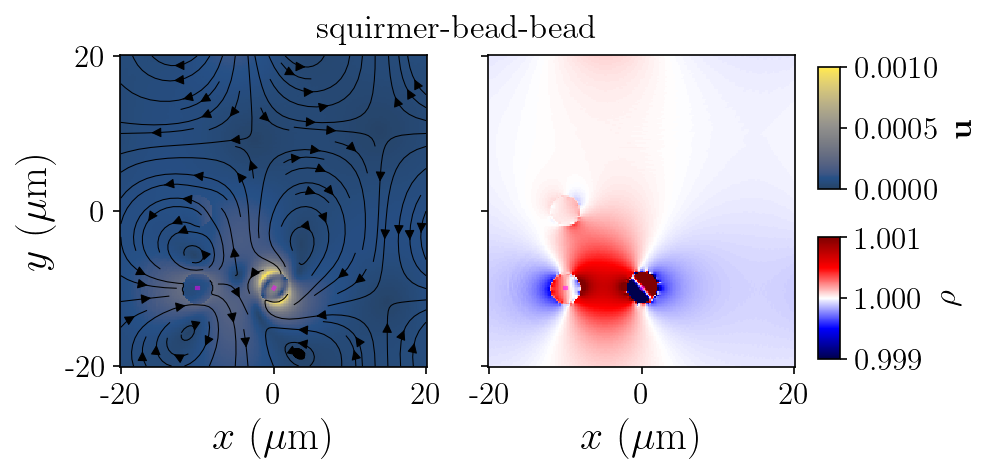

In [5]:
title = 'squirmer-bead-bead'
fig, axes = aux.fluidOverview(fluidDf, particleDf, title)
plt.show()

In [6]:
id = -1
fluidDf = pd.read_csv(dataDir + f"fluidTrj_{ticks[id]}.csv").set_index(["id_x","id_y"]).sort_index()
particleDf = pd.read_csv(dataDir+"particlesTrj.csv")

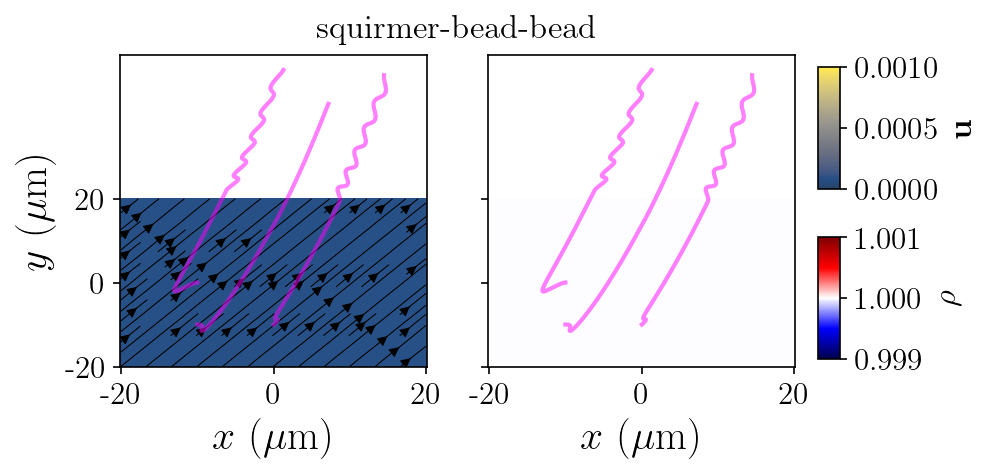

In [7]:
title = 'squirmer-bead-bead'
fig, axes = aux.fluidOverview(fluidDf, particleDf, title)
plt.show()

# Stability analysis

In [8]:
def avgSpeed(df):
    return np.sqrt(df.fluidVelocity_x**2 + df.fluidVelocity_y**2).mean()

In [9]:
try:
    avgFluidSpeed 
except NameError:
    avgFluidSpeed = []
    
try:
    time 
except NameError:
    time = []

for tick in ticks[len(time)::]:
    auxDf = pd.read_csv(dataDir + f"fluidTrj_{tick}.csv")
    avgFluidSpeed.append(avgSpeed(auxDf))
    time.append(auxDf.time.values[0])
    print(f'\r{tick}', end='', flush=True)
print('\r'+' '*10, end='', flush=True)

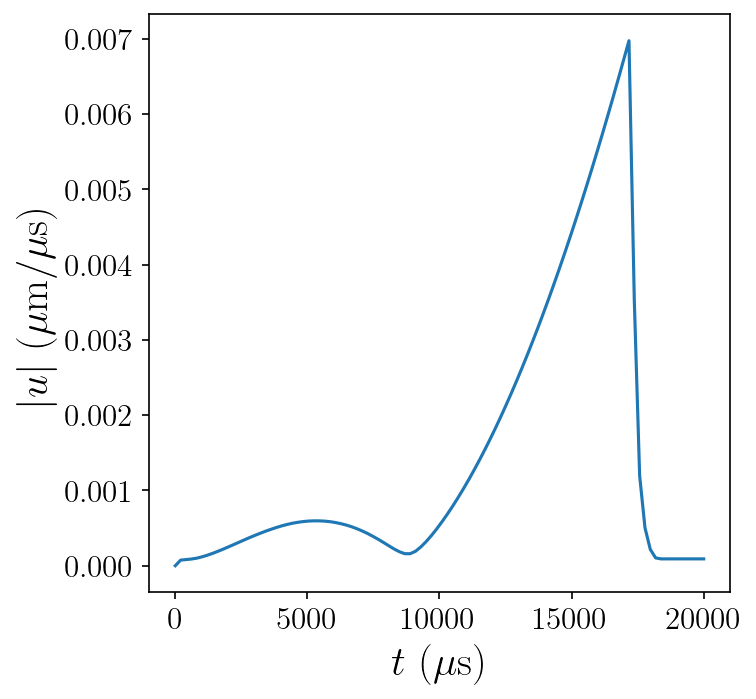

In [10]:
fig, ax = plt.subplots(figsize = (5,5))

ax.plot(time, avgFluidSpeed)
ax.set_xlabel("$t ~ (\\mu \\mathrm{s})$")
ax.set_ylabel("$|u| ~ (\\mu \\mathrm{m} / \\mu \\mathrm{s})$")

plt.show()